In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
import os
import json


competition = 'asl-signs'


plt.style.use("ggplot")

In [2]:
iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')
if iskaggle:
    path = Path('..') / 'input'  / 'competition'
    # !pip install -Uqq fastai
else:
    import zipfile, kaggle
    path = Path.home() / '.data' / 'asl-signs'
    if not path.exists():
        path.mkdir(exist_ok=True)
        kaggle.api.competition_download_cli(competition, path=path)
        zipfile.ZipFile(path / f'{competition}.zip').extractall(path)

# Labeled Data

In [3]:
with open(path / 'sign_to_prediction_index_map.json') as f:
    sign_labels = json.load(f)

In [6]:
train = (pd.read_csv(path / 'train.csv')
         .assign(idx=lambda x: x.participant_id.astype(str) + '_' + x.sequence_id.astype(str))
         .set_index('idx')
        )
train.head()

,path,participant_id,sequence_id,sign
idx,,,,
26734_1000035562,train_landmark_files/26734/1000035562.parquet,26734,1000035562,blow
28656_1000106739,train_landmark_files/28656/1000106739.parquet,28656,1000106739,wait
16069_100015657,train_landmark_files/16069/100015657.parquet,16069,100015657,cloud
25571_1000210073,train_landmark_files/25571/1000210073.parquet,25571,1000210073,bird
62590_1000240708,train_landmark_files/62590/1000240708.parquet,62590,1000240708,owie


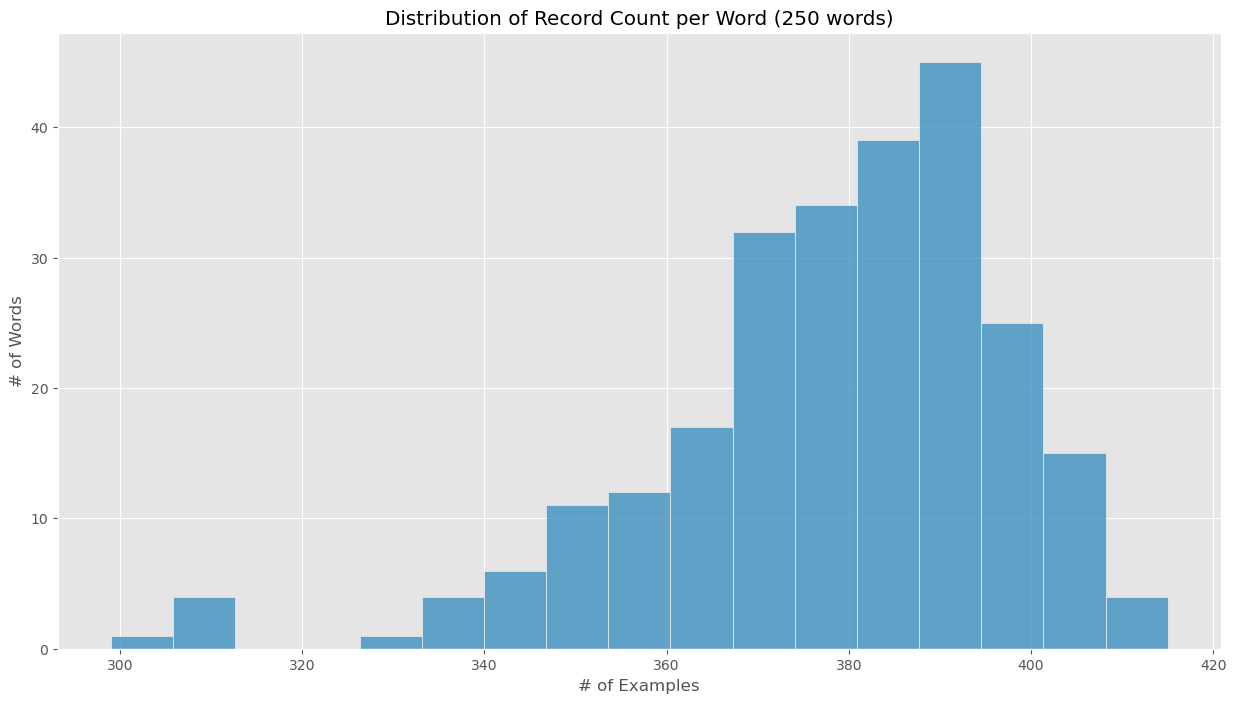

In [7]:
fig, ax = plt.subplots(figsize=(15, 8))
s = train.sign.value_counts()
ax = sns.histplot(s)
ax.set(xlabel='# of Examples', ylabel='# of Words', 
       title=f'Distribution of Record Count per Word ({len(s)} words)')
plt.show()

# Competition Data Loader

In [8]:
ROWS_PER_FRAME = 543  # number of landmarks per frame

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

# Example Data

In [53]:
# example = train.sample(1, random_state=6969).iloc[0]
example = train.iloc[7]
example

path              train_landmark_files/32319/1000278229.parquet
participant_id                                            32319
sequence_id                                          1000278229
sign                                                       lips
Name: 32319_1000278229, dtype: object

In [54]:
ex_id = str(example['participant_id']) + '_' + str(example['sequence_id'])
ex_id

'32319_1000278229'

In [55]:
pq_path = path / example['path']
ex_data = pd.read_parquet(pq_path)
ex_data.head()

,frame,row_id,type,landmark_index,x,y,z
0,4,4-face-0,face,0,0.403268,0.302308,-0.042021
1,4,4-face-1,face,1,0.401347,0.247557,-0.081271
2,4,4-face-2,face,2,0.403385,0.259085,-0.041161
3,4,4-face-3,face,3,0.380385,0.208618,-0.062687
4,4,4-face-4,face,4,0.399066,0.235711,-0.087149


In [56]:
frame_mask = ex_data.frame == 27
single_frame = ex_data.loc[frame_mask, :]
single_frame.type.value_counts()

face          468
pose           33
left_hand      21
right_hand     21
Name: type, dtype: int64

# Middle Frame

In [79]:
type_mask = ex_data.type.isin(['left_hand', 'right_hand'])
record = (ex_data.loc[type_mask, ].set_index(['frame', 'type', 'landmark_index'])
 .loc[:, ['x', 'y', 'z']]
 .melt(ignore_index=False)
 .reset_index()
 .assign(idx=lambda x: x.type + '_' + x.landmark_index.astype(str) + '_' + x.variable)
 .set_index(['frame', 'idx'])
 .drop(['type', 'landmark_index', 'variable'], axis=1)
 .unstack('idx')
 .xs('value', axis=1)
)

mask = ~record.isna().all(axis=1)
record = record.loc[mask, ]

In [80]:
min_frame, max_frame = 0, len(record)
middle_frame = int((max_frame - min_frame) / 2 + min_frame)
# min_frame, middle_frame, max_frame

record = record.iloc[middle_frame:middle_frame+1]

In [83]:
record.index = [ex_id]
record

idx,left_hand_0_x,left_hand_0_y,left_hand_0_z,left_hand_10_x,left_hand_10_y,left_hand_10_z,left_hand_11_x,left_hand_11_y,left_hand_11_z,left_hand_12_x,...,right_hand_6_z,right_hand_7_x,right_hand_7_y,right_hand_7_z,right_hand_8_x,right_hand_8_y,right_hand_8_z,right_hand_9_x,right_hand_9_y,right_hand_9_z
32319_1000278229,0.774177,0.577556,4.673167e-07,0.572779,0.400315,-0.014073,0.608326,0.40998,-0.005408,0.639125,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Middle Frame Training Data

In [135]:
class Preprocessor:
    COORD_COLS = ['x', 'y', 'z']
    def __init__(self, train_df):
        self.train_df = train_df
        self.current_df = None
        self.frames = list()
        
    
    def preprocess(self):
        for idx, row in tqdm(self.train_df.iterrows()):
            self.row_id = str(row['participant_id']) + '_' + str(row['sequence_id'])
            
            pq_path = path / row['path']
            self.row_landmarks = pd.read_parquet(pq_path)
            transformed = self.transform()
            self.frames.append(transformed)
    
    def calc_middle_frame(self):
        min_frame, max_frame = 0, len(self.record)
        middle_frame = int((max_frame - min_frame) / 2 + min_frame)
        return middle_frame
    
    def transform(self):
               
        type_mask = self.row_landmarks.type.isin(['left_hand', 'right_hand'])
        self.record = (self.row_landmarks.loc[type_mask, ]
                       .set_index(['frame', 'type', 'landmark_index'])
                       .loc[:, self.COORD_COLS]
                       .melt(ignore_index=False)
                       .reset_index()
                       .assign(idx=lambda x: x.type + '_' + x.landmark_index.astype(str) + '_' + x.variable)
                       .set_index(['frame', 'idx'])
                       .drop(['type', 'landmark_index', 'variable'], axis=1)
                       .unstack('idx')
                       .xs('value', axis=1)
                      )

        mask = ~self.record.isna().all(axis=1)
        self.record = self.record.loc[mask, ]
        
        middle_frame = self.calc_middle_frame()
        
        self.record = self.record.iloc[middle_frame:middle_frame+1]
        
        self.record.index = [self.row_id]

        return self.record

In [136]:
p = Preprocessor(train)
p.preprocess()
df = pd.concat(p.frames)

0it [00:00, ?it/s]

In [138]:
mask = ~df.isna().all(axis=1)
df.loc[mask, ].to_csv(path / 'hand_landmark_middle_frames.csv')

# Plotly Check Record Check

In [139]:
example_frame = df.iloc[7:7+1].T
idx_split = pd.Series(example_frame.index).str.split('_', expand=True).set_index(example_frame.index)
example_frame.loc[:, 'type'] = idx_split.loc[:, 0] + '_' + idx_split.loc[:, 1]
example_frame.loc[:, 'landmark'] = idx_split.loc[:, 2]
example_frame.loc[:, 'coord'] = idx_split.loc[:, 3]

example_frame = (example_frame.set_index(['type', 'landmark', 'coord'])
                 .unstack('coord')
                 .xs('32319_1000278229',axis=1)
                 .reset_index()
                )

In [140]:
import plotly.express as px

px.scatter_3d(example_frame, x="x", y="y", z="z", color="type", hover_name='landmark')

# Initial Model

In [141]:
import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [142]:
df = (pd.read_csv(path / 'hand_landmark_middle_frames.csv')
      .rename(columns={'Unnamed: 0': 'idx'})
      .set_index('idx')
     )

In [143]:
train_with_features = (train.join(df, how='inner')
                       .assign(label=lambda x: x.sign.map(sign_labels))
                      )

In [193]:
class ALSDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X.fillna(-1).values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [194]:
X = train_with_features.loc[:, df.columns.tolist()]
y = train_with_features.loc[:, 'label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42, 
                                                    stratify=train_with_features.sign)

train_ds = ALSDataset(X_train, y_train)
test_ds = ALSDataset(X_test, y_test)

train_dataloader = DataLoader(train_ds,batch_size=128,shuffle=True)
test_dataloader = DataLoader(test_ds,batch_size=128,shuffle=False)

In [196]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [207]:
class ALSModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(126, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 250),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits
    
model = ALSModel()

In [234]:
learning_rate = 0.005
batch_size = 128
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [235]:
def train_loop(dataloader, model, loss_fn, optimizer, print_loss_per_epoch=False):
    size = len(dataloader.dataset)
    for batch, (X, y) in enumerate(dataloader):
        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if print_loss_per_epoch and batch % 100 == 0:
                loss, current = loss.item(), (batch + 1) * len(X)
                print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")


def test_loop(dataloader, model, loss_fn, print_acc=False):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= size
    if print_acc:
        print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [236]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

epochs = 40
for t in range(epochs):
    if t % 10 == 0:
        print(f"Epoch {t+1}\n-------------------------------")
        print_acc = True
    else:
        print_acc = False
    train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loop(test_dataloader, model, loss_fn, print_acc)
print("Done!")

Epoch 1
-------------------------------
Test Error: 
 Accuracy: 44.4%, Avg loss: 2.414217 

Epoch 11
-------------------------------
Test Error: 
 Accuracy: 44.5%, Avg loss: 2.412241 

Epoch 21
-------------------------------
Test Error: 
 Accuracy: 44.3%, Avg loss: 2.412017 

Epoch 31
-------------------------------
Test Error: 
 Accuracy: 44.5%, Avg loss: 2.413403 

Done!


# Error Analysis

In [237]:
with torch.no_grad():
    for X, y in test_dataloader:
        pred = model(X)

In [238]:
with torch.no_grad():
    X, y = test_dataloader.dataset.X, test_dataloader.dataset.y
    pred = model(X).argmax(1)

In [239]:
preds = pd.DataFrame(y_test).assign(predicted=pred)

In [240]:
sign_labels_inverse = {v: k for k, v in sign_labels.items()}

In [241]:
preds = preds.assign(label=lambda x: x.label.map(sign_labels_inverse),
                     predicted=lambda x: x.predicted.map(sign_labels_inverse),
                     correct=lambda x: (x.label==x.predicted).astype(int)
                    )

In [242]:
(preds.groupby('label')
 .agg(
     correct=pd.NamedAgg('correct', 'sum'),
     total=pd.NamedAgg('label', 'count')
 )
 .assign(accuracy=lambda x: x.correct.div(x.total))
 .sort_values('accuracy', ascending=False)
 .to_csv('accuracy_by_word_actual.csv')
)

In [243]:
(preds.groupby('predicted')
 .agg(
     correct=pd.NamedAgg('correct', 'sum'),
     total=pd.NamedAgg('label', 'count')
 )
 .assign(accuracy=lambda x: x.correct.div(x.total))
 .sort_values('accuracy', ascending=False)
 .to_csv('accuracy_by_word_predicted.csv')
)

# Tensorflow Conversion

In [244]:
!pip install onnx-tf
!pip install tflite-runtime

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.1/226.1 kB 4.1 MB/s eta 0:00:0000:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:00a 0:00:01
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: pip install --upgrade pip
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement tflite-runtime (from versions: none)
ERROR: No matching distribution found for tflite-runtime

[notice] A new release of pip available: 22.3 -> 23.0.1
[notice] To update, run: pip install --upgrade pip


# Submissions

In [ ]:
import tflite_runtime.interpreter as tflite
interpreter = tflite.Interpreter(model_path)

found_signatures = list(interpreter.get_signature_list().keys())

if REQUIRED_SIGNATURE not in found_signatures:
    raise KernelEvalException('Required input signature not found.')

prediction_fn = interpreter.get_signature_runner("serving_default")
output = prediction_fn(inputs=frames)
sign = np.argmax(output["outputs"])